# Script to scan the PSSS camera focus position
### Purpose:
The detection plane of the PSSS is imaged by a screen and camera. This script will scan the camera position find the focal plane

Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
%matplotlib inline
from IPython.display import clear_output, display

## Setup and functions setup

In [48]:
PSSS_FWHM_name = 'SARFE10-PSSS059:SPECTRUM_FWHM'
PSSS_screen_z_name = 'SARFE10-PSSS059:MOTOR_Z5'
PSSS_e_axis_name = 'SARFE10-PSSS059:SPECTRUM_X'
PSSS_spectrum_name = 'SARFE10-PSSS059:SPECTRUM_Y'

PSSS_FWHM_PV = ep.PV(PSSS_FWHM_name)
PSSS_screen_z_PV = ep.PV(PSSS_screen_z_name)
PSSS_spectrum_PV = ep.PV(PSSS_spectrum_name)
PSSS_e_axis_PV = ep.PV(PSSS_e_axis_name)

def set_screen_z(pos):
    PSSS_screen_z_PV.put(pos, wait=True)

def PSSS_screen_z_scan(Range, NumShots):
        
    screen_scan = []
            
    for pos in Range:
        set_screen_z(pos)
        sleep(2)
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PSSS_spectrum_PV.add_callback(callback=on_value_change, pv =PSSS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        screen_scan.append(np.array(Spectrum_this_energy))

    spec_out = rm_bkg(np.array(screen_scan))
        
    return spec_out

def rm_bkg(spec):
    for i in range(0,spec.shape[0]):
        spec[i] = spec[i] - spec[i].mean(axis=0)[0:100].mean()
    return spec

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def bimodal(x, H_1, A_1, x0_1, sigma_1,H_2, A_2, x0_2, sigma_2):
    return gauss(x, H_1, A_1, x0_1, sigma_1)+gauss(x, H_2, A_2, x0_2, sigma_2)

def trimodal(x, H_1, A_1, x0_1, sigma_1,H_2, A_2, x0_2, sigma_2,H_3, A_3, x0_3, sigma_3):
    if any(val <0 for val in [H_1, A_1, x0_1, sigma_1,H_2, A_2, x0_2, sigma_2,H_3, A_3, x0_3, sigma_3]):
        return np.zeros_like(x)
    else:
        return gauss(x, H_1, A_1, x0_1, sigma_1)+gauss(x, H_2, A_2, x0_2, sigma_2)+gauss(x, H_3, A_3, x0_3, sigma_3)

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

# def bimodal_fit(x, y):
#     mean = sum(x * y) / sum(y)
#     sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
#     print(mean, sigma)
#     p0 = [min(y), max(y), mean, sigma/10,min(y), max(y), mean, sigma]
#     print(p0)
#     popt, pcov = curve_fit(bimodal, x, y, p0=p0,maxfev=1000)
    
#     return popt

def auto_corr(e_axis, Spec):
    correlations = np.zeros_like(Spec)
    correlations = []
    for i in range(0,Spec.shape[0]):
        test = np.correlate(Spec[i,:].astype('float'),Spec[i,:].astype('float'), mode='same')
#         correlations[i,:] = test
        correlations.append(test)
    lags = e_axis - e_axis[int(e_axis.size /2)]
    correlations = np.asarray(correlations)
#     print(correlations.shape)
    return lags, correlations.mean(axis=0)


def bimodal_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(bimodal, x, y, p0=[min(y), max(y)-min(y), mean, sigma,min(y), max(y), mean/100, sigma/100])
#     popt, pcov = curve_fit(bimodal, x, y, p0=[min(y), max(y), mean, sigma, min(y), max(y), mean/10, sigma/10])
    
    return popt

def trimodal_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(trimodal, x, y, p0=[min(y), max(y), mean, sigma,min(y), max(y), mean, sigma, min(y), max(y), mean/100, sigma/100])
    return popt



## User inputs - define travel range of crystal
It is unlikely these values need to be changed

In [23]:
screen_z_from = -0.0
screen_z_to = 0.0
steps = 1
NumShots= 250
screen_z_range = np.linspace(screen_z_from, screen_z_to, steps)

## Scan and take data

In [45]:
Scan_spec = PSSS_screen_z_scan(screen_z_range,NumShots)
e_axis = PSSS_e_axis_PV.get()

In [49]:
peak_width = []
spectral_width = []
for i in range(0, len(screen_z_range)):
    lags, mean_cor = auto_corr(e_axis,Scan_spec[i])
#     mean_cor = mean_cor - mean_cor[0:10].mean()
    lags = lags.astype(dtype=np.float32)
    mean_cor = mean_cor.astype(dtype=np.float32)
    
    popt = gauss_fit(lags, mean_cor)
    mean_cor_zero = mean_cor - gauss(lags,*popt)
    bpopt = bimodal_fit(lags, mean_cor)
#     tpopt = trimodal_fit(lags, mean_cor)
    
    peak_width.append(2.355*bpopt[-1])
    spectral_width.append(2.355*bpopt[3])
print(bpopt)

[-1.73728099e+12  1.41499739e+10  8.57669466e-05  1.28095667e+01
  1.73700034e+12  2.57531101e+10  6.00190955e-06  7.65390471e+00]


In [ ]:
# popt = gauss_fit(lags, mean_cor)
# bpopt = bimodal_fit(lags, mean_cor)
# peak_width = 2.355*bpopt[-1]
# spectral_width = 2.355*bpopt[3]

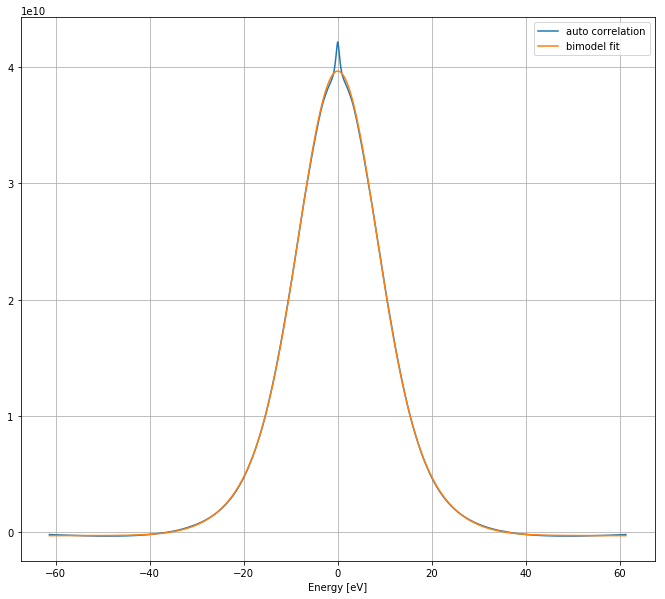

In [50]:
plt.figure(figsize=[25,10])
# plt.suptitle('Run: '+ run_name[-10:] +'\nSpectal width %.2f'%spectral_width+ ' [eV], spike width %.2f'%peak_width+ ' [eV]')
plt.subplot(121)
plt.plot(lags,mean_cor, label ='auto correlation')
plt.plot(lags,bimodal(lags,*bpopt), label ='bimodel fit')
# plt.plot(lags,trimodal(lags,*tpopt), label ='bimodel fit')

plt.xlabel('Energy [eV]')
plt.grid(True)
plt.legend()
# plt.subplot(122)
# plt.plot(lags,gauss(lags,*bpopt[-4:]), label ='Gauss fit')
# plt.xlabel('Energy [eV]')
# plt.xlim([-5*bpopt[-1],5*bpopt[-1]])
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

In [17]:

test = Scan_spec[0]- Scan_spec[0].mean(axis=0)[0:100].mean()

In [18]:
test.shape

(250, 2560)

In [21]:
def rm_bkg(spec):
    for i in spec.shape[0]:
        spec[i] = spec[i].mean(axis=0) - spec[i].mean(axis=0)[0:100].mean()

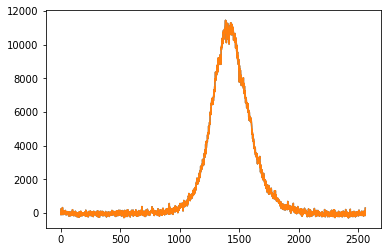

In [31]:
plt.figure()
plt.plot(Scan_spec[0,0,:])
plt.plot(Scan_spec[0].mean(axis=0))

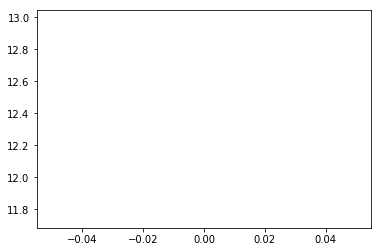

In [8]:
plt.figure()
plt.plot(screen_z_range,peak_width)

## Plot and return maxium position


In [ ]:
course_scan = Scan_spec.mean(axis=1)

In [ ]:
plt.figure()
plt.title('Scan of detection plane of PSSS')
plt.plot(screen_z_range, Scan_spec.mean(axis=1), label = 'mean of 1000 pulses')
plt.fill_between(screen_z_range,Scan_spec.mean(axis=1)-Scan_spec.std(axis=1),Scan_spec.mean(axis=1)+Scan_spec.std(axis=1), alpha = 0.1)
plt.legend()
plt.xlim([-0.1,0.1])
plt.ylabel(PSSS_FWHM_name)
plt.xlabel(PSSS_screen_z_name)
plt.grid(True)

In [ ]:
projection = Scan_spec.mean(axis=1).mean(axis=1)
signal_centre = xstal_range[np.argmax(projection)]
xstal_range_fit = np.linspace(xstal_range[0], xstal_range[-1], len(xstal_range)*10)
energy_axis = PSSS_e_axis_PV.get()
try:
    popt,pcov = curve_fit(gaus,xstal_range,projection,p0=[100,signal_centre,-0.2,100])
except:
    print('Fit failed: spectrum might not be near scan range center')
    popt = [0.0, 0.0, 0.0, 0.0]
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('PSSS scan of crystal height')
plt.pcolormesh(energy_axis, xstal_range, Scan_spec.mean(axis=1),cmap='CMRmap')
plt.xlim([energy_axis[0],energy_axis[-1]])
plt.ylim([xstal_range[0], xstal_range[-1]])
plt.xlabel('PSSS energy axis')
plt.ylabel('Set crystal position [mm] \n'+PSSS_xstal_height_name[0:-4])
plt.subplot(122)
plt.plot(projection,xstal_range,linewidth = 2, color = 'orange',label ='projected signal')
plt.plot(gaus(xstal_range_fit,*popt),xstal_range_fit,'r:',label='fit')
plt.ylim([xstal_range[0], xstal_range[-1]])
plt.title('Signal max at %.3f [mm] (from fit)'%popt[1])
plt.xticks([])
plt.legend()
plt.grid(True)

## Set max position
Cell below will push the maximum position to the xstal height

In [ ]:
set_xstal_height(popt[1])